**Authors:** Anowar Shajib

In [1]:
from util import *

# JWST pipe version = 1.12.5
# STCAL version = 1.4.4


In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from matplotlib.collections import LineCollection

In [3]:
sflat_path = glob.glob(os.environ["CRDS_PATH"] + "references/jwst/nirspec/*sflat*"
                                                 ".fits")[0]

sflat_path

'/Users/ajshajib/Research/1131_JWST/CRDS/references/jwst/nirspec/jwst_nirspec_sflat_0194.fits'

In [4]:
sflat, header = fits.getdata(sflat_path, header=True)

Text(0.5, 1.0, 'Original SFLAT')

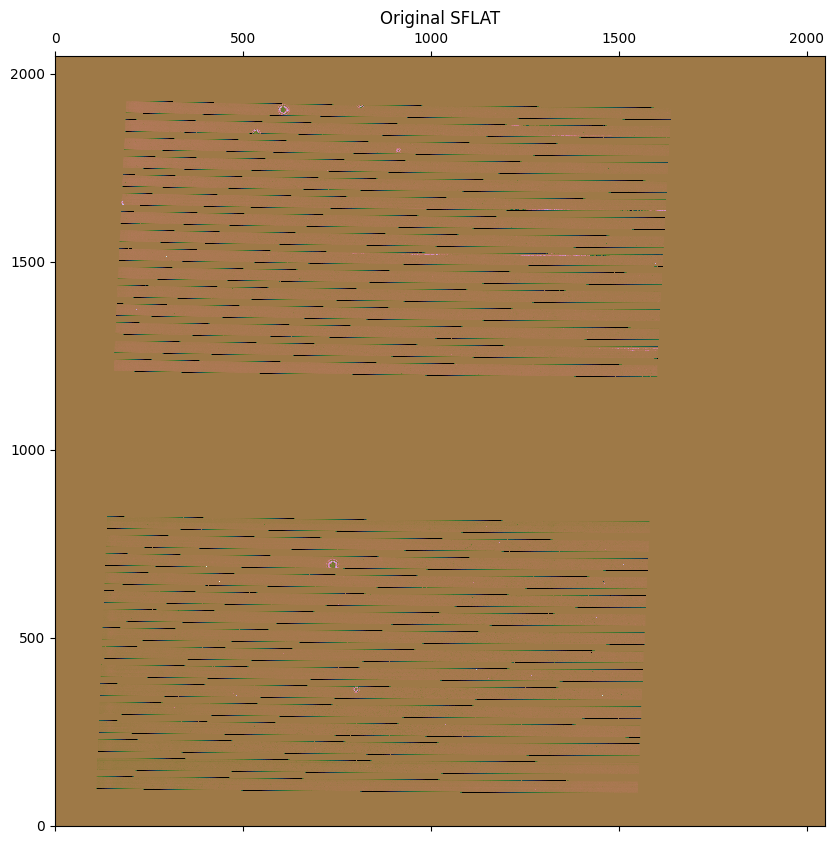

In [5]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 10))

ax.matshow(np.log10(sflat), cmap='cubehelix',
            vmin=-1, vmax=1, origin="lower"
            )
ax.set_title("Original SFLAT")

In [6]:
box_corners = [
    [591, 624, 1890, 1920],
    [798, 824, 1905, 1919],
    [520, 548, 1840, 1856],
    [904, 920, 1787, 1803],
    [174, 184, 1650, 1667],
    [718, 757, 683, 711],
    [789, 811, 352, 373]
]



In [7]:
def get_all_edges(bool_img):
    """
    Get a list of all edges (where the value changes from True to False) in the 2D boolean image.
    The returned array edges has he dimension (n, 2, 2).
    Edge i connects the pixels edges[i, 0, :] and edges[i, 1, :].
    Note that the indices of a pixel also denote the coordinates of its lower left corner.
    """
    edges = []
    ii, jj = np.nonzero(bool_img)
    for i, j in zip(ii, jj):
        # North
        if j == bool_img.shape[1]-1 or not bool_img[i, j+1]:
            edges.append(np.array([[i, j+1],
                                   [i+1, j+1]]))
        # East
        if i == bool_img.shape[0]-1 or not bool_img[i+1, j]:
            edges.append(np.array([[i+1, j],
                                   [i+1, j+1]]))
        # South
        if j == 0 or not bool_img[i, j-1]:
            edges.append(np.array([[i, j],
                                   [i+1, j]]))
        # West
        if i == 0 or not bool_img[i-1, j]:
            edges.append(np.array([[i, j],
                                   [i, j+1]]))

    if not edges:
        return np.zeros((0, 2, 2))
    else:
        return np.array(edges)


def close_loop_edges(edges):
    """
    Combine thee edges defined by 'get_all_edges' to closed loops around objects.
    If there are multiple disconnected objects a list of closed loops is returned.
    Note that it's expected that all the edges are part of exactly one loop (but not necessarily the same one).
    """

    loop_list = []
    while edges.size != 0:

        loop = [edges[0, 0], edges[0, 1]]  # Start with first edge
        edges = np.delete(edges, 0, axis=0)

        while edges.size != 0:
            # Get next edge (=edge with common node)
            ij = np.nonzero((edges == loop[-1]).all(axis=2))
            if ij[0].size > 0:
                i = ij[0][0]
                j = ij[1][0]
            else:
                loop.append(loop[0])
                # Uncomment to to make the start of the loop invisible when plotting
                # loop.append(loop[1])
                break

            loop.append(edges[i, (j + 1) % 2, :])
            edges = np.delete(edges, i, axis=0)

        loop_list.append(np.array(loop))

    return loop_list


def plot_outlines(bool_img, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    edges = get_all_edges(bool_img=bool_img)
    edges = edges - 0.5  # convert indices to coordinates; TODO adjust according to image extent
    outlines = close_loop_edges(edges=edges)
    cl = LineCollection(outlines, **kwargs)
    ax.add_collection(cl)


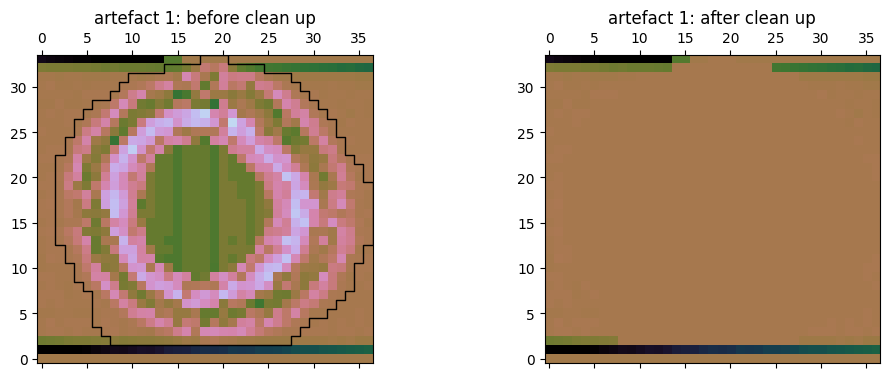

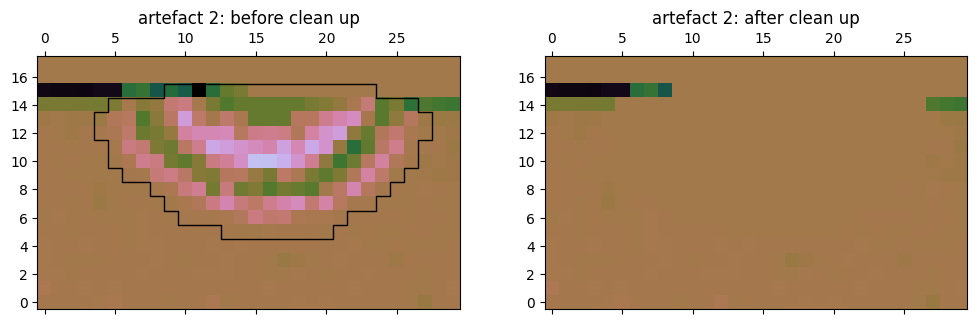

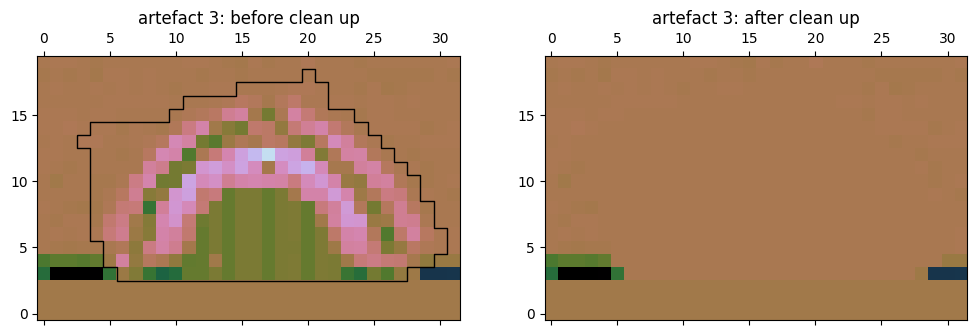

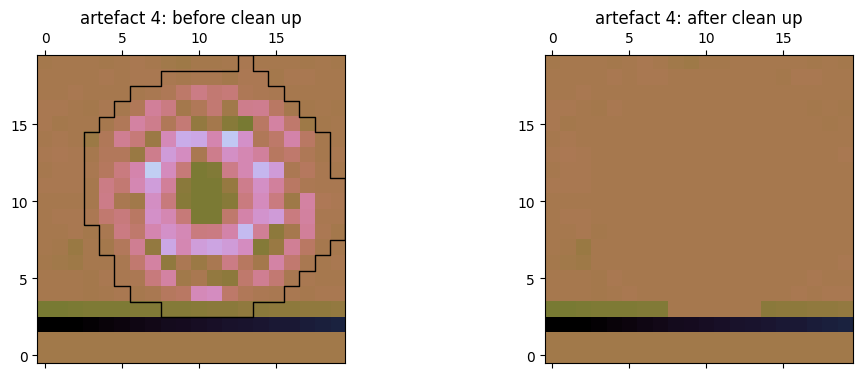

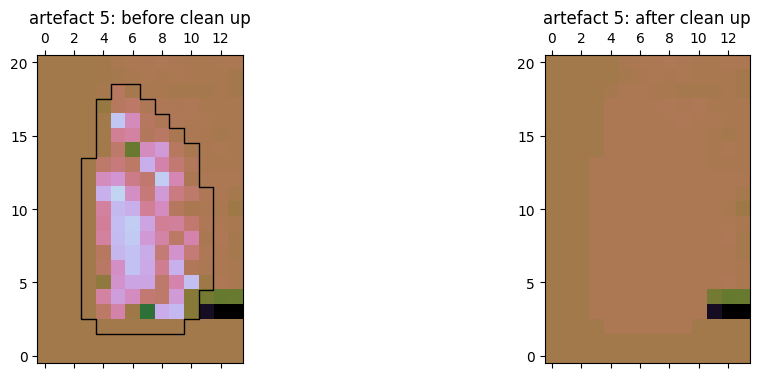

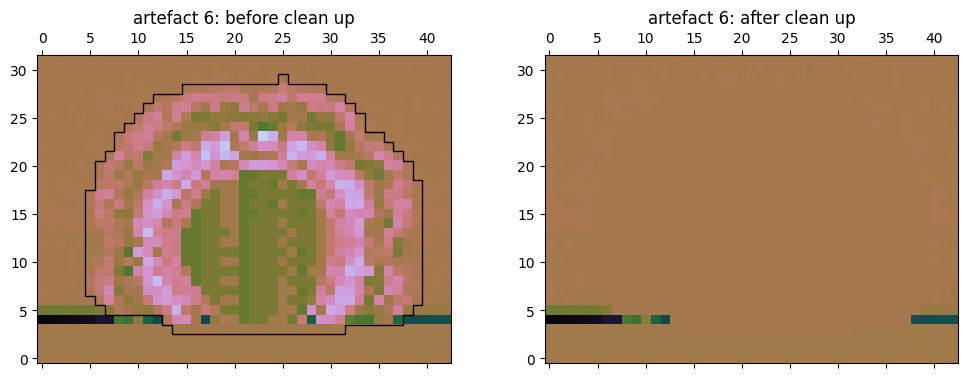

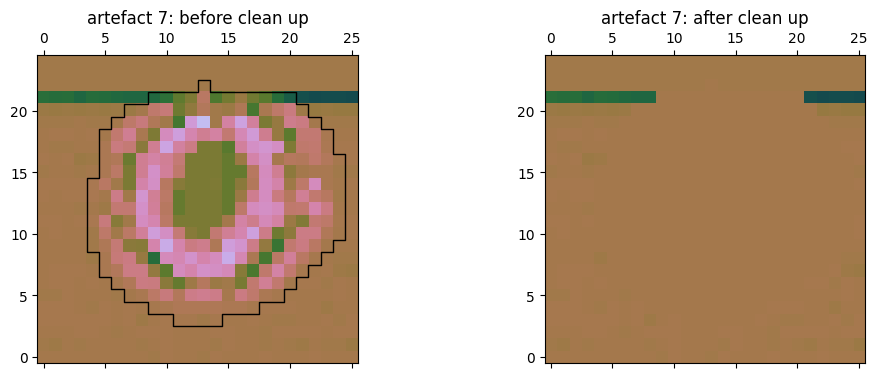

In [8]:
%matplotlib inline

for n, box_corner in enumerate(box_corners):
    ys, xs = box_corner[:2], box_corner[2:]
    
    slice = np.copy(sflat[xs[0]-2:xs[1]+2, ys[0]-2:ys[1]+2])
    slice_right = np.copy(sflat[xs[0]+2:xs[1]-2, ys[1]+2:ys[1]+30]) 
    mean = np.nanmean(slice_right)
    std = np.nanstd(slice_right)
    
    mask = np.zeros_like(slice)
    mask[slice > mean + 2.*std] = 1
    
    mask_temp = np.copy(mask)
    
    mask = ndimage.binary_fill_holes(mask)
    
    # turn off true pixels that are far from other true pixels
    size = 3
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i, j] == 1:
                if np.sum(mask[i-size:i+size+1, j-size:j+size+1]) < 2:
                    mask[i, j] = 0
    
    # fill in first and last zero in rows with zeros
    for i in range(mask.shape[0]):
        if np.any(mask[i] == 1):
            first_index = np.argwhere(mask[i] == 1)[0][0]
            last_index = np.argwhere(mask[i] == 1)[-1][0]

            mask[i][first_index:last_index] = 1

    for i in range(mask.shape[1]):
        if np.any(mask[:, i] == 1):
            first_index = np.argwhere(mask[:, i] == 1)[0][0]
            last_index = np.argwhere(mask[:, i] == 1)[-1][0]

            mask[:, i][first_index:last_index] = 1 
    
    mask = ndimage.binary_dilation(mask)
    
    slice_copy = np.copy(slice)
    slice_copy[mask] = np.nanmedian(slice_right)
    
    sflat[xs[0]-2:xs[1]+2, ys[0]-2:ys[1]+2] = slice_copy
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].matshow(np.log10(slice), vmax=1, vmin=-1, origin="lower", 
                cmap='cubehelix',)
    axes[0].set_title(f"artefact {n+1}: before clean up")
    plot_outlines(mask.T, ax=axes[0], lw=1, color='black')
    
    axes[1].matshow(np.log10(slice_copy), vmax=1, vmin=-1, 
                    origin="lower", cmap='cubehelix')
    axes[1].set_title(f"artefact {n+1}: after clean up")
    plt.show()

Text(0.5, 1.0, 'Cleaned-up SFLAT')

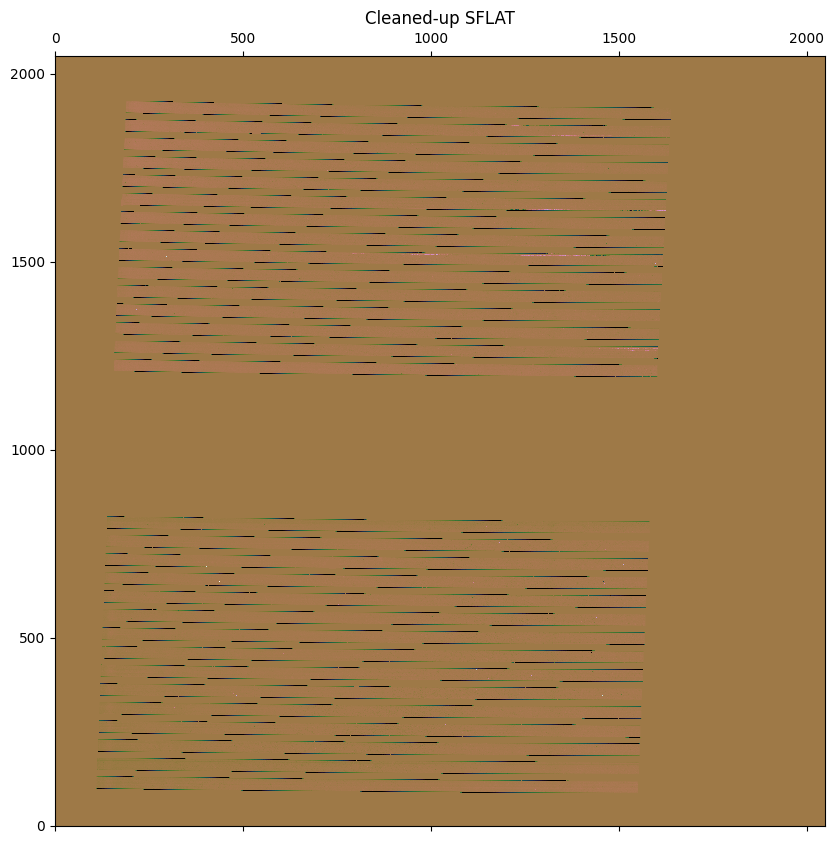

In [9]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 10))

ax.matshow(np.log10(sflat), cmap='cubehelix',
            vmin=-1, vmax=1, origin="lower"
            )
ax.set_title("Cleaned-up SFLAT")

In [10]:
fits.writeto(os.path.split(sflat_path)[1][:-5] + "_cleaned.fits", 
             sflat, overwrite=True, header=header)